In [1]:
import urllib.request, urllib.error, urllib.parse
import sys
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot

In [2]:
def S(z,gamma):
    if gamma >= fabs(z):
        return 0.0
    if z > 0.0:
        return z - gamma
    else:
        return z + gamma

def Pr(b0,b,x):
    n = len(x)
    sum = b0
    for i in range(n):
        sum += b[i]*x[i]
        if sum < -100: sum = -100
    return 1.0/(1.0 + exp(-sum))


In [3]:
#read data from uci data repository
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
data = urllib.request.urlopen(target_url)


#arrange data into list for labels and list of lists for attributes
xList = []


for line in data:
    #split on comma
    row = line.decode().strip().split(",")
    xList.append(row)

#separate labels from attributes, convert from attributes from string to numeric and convert "M" to 1 and "R" to 0

xNum = []
labels = []

for row in xList:
    lastCol = row.pop()
    if lastCol == "M":
        labels.append(1.0)
    else:
        labels.append(0.0)
    attrRow = [float(elt) for elt in row]
    xNum.append(attrRow)

In [4]:
#number of rows and columns in x matrix
nrow = len(xNum)
ncol = len(xNum[1])

alpha = 0.8
#calculate means and variances
xMeans = []
xSD = []
for i in range(ncol):
    col = [xNum[j][i] for j in range(nrow)]
    mean = sum(col)/nrow
    xMeans.append(mean)
    colDiff = [(xNum[j][i] - mean) for j in range(nrow)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrow)])
    stdDev = sqrt(sumSq/nrow)
    xSD.append(stdDev)

#use calculate mean and standard deviation to normalize xNum
xNormalized = []
for i in range(nrow):
    rowNormalized = [(xNum[i][j] - xMeans[j])/xSD[j] for j in range(ncol)]
    xNormalized.append(rowNormalized)

#Do Not Normalize labels but do calculate averages
meanLabel = sum(labels)/nrow
sdLabel = sqrt(sum([(labels[i] - meanLabel) * (labels[i] - meanLabel) for i in range(nrow)])/nrow)

In [5]:
#initialize probabilities and weights
sumWxr = [0.0] * ncol
sumWxx = [0.0] * ncol
sumWr = 0.0
sumW = 0.0

#calculate starting points for betas
for iRow in range(nrow):
    p = meanLabel
    w = p * (1.0 - p)
    #residual for logistic
    r = (labels[iRow] - p) / w
    x = xNormalized[iRow]
    sumWxr = [sumWxr[i] + w * x[i] * r for i in range(ncol)]
    sumWxx = [sumWxx[i] + w * x[i] * x[i] for i in range(ncol)]
    sumWr = sumWr + w * r
    sumW = sumW + w

avgWxr = [sumWxr[i]/nrow for i in range(ncol)]
avgWxx = [sumWxx[i]/nrow for i in range(ncol)]

maxWxr = 0.0
for i in range(ncol):
    val = abs(avgWxr[i])
    if val > maxWxr:
        maxWxr = val

#calculate starting value for lambda
lam = maxWxr/alpha

#this value of lambda corresponds to beta = list of 0's
#initialize a vector of coefficients beta
beta = [0.0] * ncol
beta0 = sumWr/sumW

#initialize matrix of betas at each step
betaMat = []
betaMat.append(list(beta))

beta0List = []
beta0List.append(beta0)


In [6]:
#begin iteration
nSteps = 100
lamMult = 0.93 #100 steps gives reduction by factor of 1000 in lambda (recommended by authors)
nzList = []
for iStep in range(nSteps):
    #decrease lambda
    lam = lam * lamMult


    #Use incremental change in betas to control inner iteration


    #set middle loop values for betas = to outer values
    # values are used for calculating weights and probabilities
    #inner values are used for calculating penalized regression updates

    #take pass through data to calculate averages over data require for iteration
    #initilize accumulators

    betaIRLS = list(beta)
    beta0IRLS = beta0
    distIRLS = 100.0
    #Middle loop to calculate new betas with fixed IRLS weights and probabilities
    iterIRLS = 0
    while distIRLS > 0.01:
        iterIRLS += 1
        iterInner = 0.0

        betaInner = list(betaIRLS)
        beta0Inner = beta0IRLS
        distInner = 100.0
        while distInner > 0.01:
            iterInner += 1
            if iterInner > 100: break

            #cycle through attributes and update one-at-a-time
            #record starting value for comparison
            betaStart = list(betaInner)
            for iCol in range(ncol):

                sumWxr = 0.0
                sumWxx = 0.0
                sumWr = 0.0
                sumW = 0.0

                for iRow in range(nrow):
                    x = list(xNormalized[iRow])
                    y = labels[iRow]
                    p = Pr(beta0IRLS, betaIRLS, x)
                    if abs(p) < 1e-5:
                        p = 0.0
                        w = 1e-5
                    elif abs(1.0 - p) < 1e-5:
                        p = 1.0
                        w = 1e-5
                    else:
                        w = p * (1.0 - p)

                    z = (y - p) / w + beta0IRLS + sum([x[i] * betaIRLS[i] for i in range(ncol)])
                    r = z - beta0Inner - sum([x[i] * betaInner[i] for i in range(ncol)])
                    sumWxr += w * x[iCol] * r
                    sumWxx += w * x[iCol] * x[iCol]
                    sumWr += w * r
                    sumW += w

                avgWxr = sumWxr / nrow
                avgWxx = sumWxx / nrow

                beta0Inner = beta0Inner + sumWr / sumW
                uncBeta = avgWxr + avgWxx * betaInner[iCol]
                betaInner[iCol] = S(uncBeta, lam * alpha) / (avgWxx + lam * (1.0 - alpha))

            sumDiff = sum([abs(betaInner[n] - betaStart[n]) for n in range(ncol)])
            sumBeta = sum([abs(betaInner[n]) for n in range(ncol)])
            distInner = sumDiff/sumBeta
        #print number of steps for inner and middle loop convergence to monitor behavior
        #print(iStep, iterIRLS, iterInner)

        #if exit inner while loop, then set betaMiddle = betaMiddle and run through middle loop again.

        #Check change in betaMiddle to see if IRLS is converged
        a = sum([abs(betaIRLS[i] - betaInner[i]) for i in range(ncol)])
        b = sum([abs(betaIRLS[i]) for i in range(ncol)])
        distIRLS = a / (b + 0.0001)
        dBeta = [betaInner[i] - betaIRLS[i] for i in range(ncol)]
        gradStep = 1.0
        temp = [betaIRLS[i] + gradStep * dBeta[i] for i in range(ncol)]
        betaIRLS = list(temp)

    beta = list(betaIRLS)
    beta0 = beta0IRLS
    betaMat.append(list(beta))
    beta0List.append(beta0)

    nzBeta = [index for index in range(ncol) if beta[index] != 0.0]
    for q in nzBeta:
        if not(q in nzList):
            nzList.append(q)


Attributes Ordered by How Early They Enter the Model
['V10', 'V48', 'V11', 'V44', 'V35', 'V51', 'V20', 'V3', 'V50', 'V21', 'V43', 'V47', 'V15', 'V27', 'V0', 'V22', 'V36', 'V30', 'V53', 'V56', 'V58', 'V6', 'V19', 'V28', 'V39', 'V49', 'V7', 'V23', 'V54', 'V8', 'V14', 'V2', 'V29', 'V38', 'V57', 'V45', 'V13', 'V32', 'V31', 'V42', 'V16', 'V37', 'V59', 'V52', 'V25', 'V18', 'V1', 'V33', 'V4', 'V55', 'V17', 'V46', 'V26', 'V12', 'V40', 'V34', 'V5', 'V24', 'V41', 'V9']


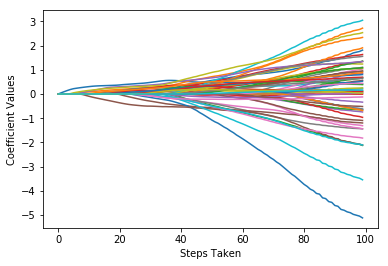

In [7]:
#make up names for columns of xNum
names = ['V' + str(i) for i in range(ncol)]
nameList = [names[nzList[i]] for i in range(len(nzList))]

print("Attributes Ordered by How Early They Enter the Model")
print(nameList)
for i in range(ncol):
    #plot range of beta values for each attribute
    coefCurve = [betaMat[k][i] for k in range(nSteps)]
    xaxis = range(nSteps)
    plot.plot(xaxis, coefCurve)

plot.xlabel("Steps Taken")
plot.ylabel("Coefficient Values")
plot.show()